## Travel Insurance Prediction Models

### Import the necessary libraries

In [112]:
# necessary libraries
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import time
#import pickle
warnings.filterwarnings('ignore')
from pathlib import Path

# pipeline & models essentials
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# feature selection
#from sklearn.inspection import (partial_dependence, PartialDependenceDisplay)
#import partial_dependence as pdp_plot
import shap
from sklearn.feature_selection import SelectKBest 
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import chi2
from mrmr import mrmr_classif

# metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve

# sampling
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# scallers
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

# models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

### Read Data

In [54]:
path = Path("TravelInsurancePrediction.csv")
file_path = str(Path().parent.absolute().parent.absolute()) + '\\01. Data\\Cleaned_Data.csv'
df = pd.read_csv(file_path)
df = df.drop('Unnamed: 0', axis=1)
df

,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,31,1,1,400000,6,1,0,0,0
1,31,0,1,1250000,7,0,0,0,0
2,34,0,1,500000,4,1,0,0,1
3,28,0,1,700000,3,1,0,0,0
4,28,0,1,700000,8,1,1,0,0
...,...,...,...,...,...,...,...,...,...
1982,33,0,1,1500000,4,0,1,1,1
1983,28,0,1,1750000,5,1,0,1,0
1984,28,0,1,1150000,6,1,0,0,0
1985,34,0,1,1000000,6,0,1,1,1


### Split Data 

<Axes: xlabel='TravelInsurance', ylabel='count'>

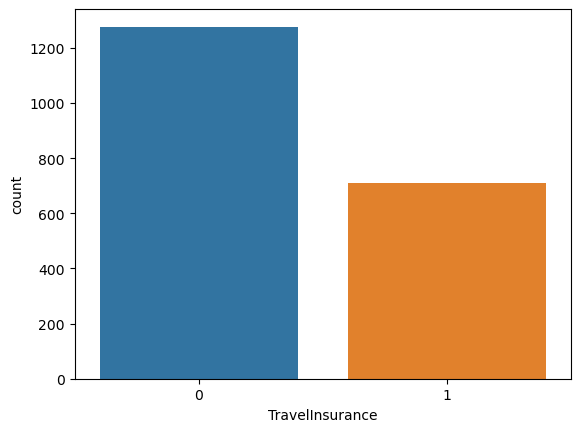

In [55]:
sns.countplot(x=df["TravelInsurance"])

In [56]:
X = df.drop('TravelInsurance', axis=1)
y = df['TravelInsurance']

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)
print("y_train: ", y_train.shape)
print("y_test: ", y_test.shape)

X_train:  (1490, 8)
X_test:  (497, 8)
y_train:  (1490,)
y_test:  (497,)


### Test Models

In [82]:
#num_features = [3,5,7,8]

scalers = [
    #('None',''),
    ('StandardScaler', StandardScaler()),
    ('MinMaxScaler', MinMaxScaler()),
    ('RobustScaler', RobustScaler())
]

resamplers = [
    #('None',''),
    ('SMOTE', SMOTE()),
    ('NearMiss', NearMiss()),
    ('Oversampling', RandomOverSampler()),
    ('Undersampling', RandomUnderSampler())
]

classifiers = [
    ('Random Forest', RandomForestClassifier(n_estimators=500, max_depth=7, random_state=0)),
    #('Logistic Regression', LogisticRegression()),
    #('SVC', SVC()),
    #('KNN', KNeighborsClassifier()),
    #('GaussianNB', GaussianNB()),
    ('Ada Boost', AdaBoostClassifier(n_estimators=500, learning_rate=0.01, random_state=0)),
    ('Gradient Boost', GradientBoostingClassifier(n_estimators=500, learning_rate=0.01, random_state=0)),
    #('XGBoost', XGBClassifier(n_estimators=500, learning_rate=0.01, random_state=0)),
    ('Cat Boost', CatBoostClassifier(n_estimators=500, learning_rate=0.01, random_state=0)),
    #('LightGBM', LGBMClassifier(n_estimators=500, learning_rate=0.01, random_state=0))
]

In [83]:
df_res = pd.DataFrame(columns=['Resampler', 
                               'Scaler', 
                               #'Feature_Selection',
                               'Classifier', 
                               'Accuracy',
                               'F1-Score Macro', 
                               'Balanced Accuracy', 
                               'Training Time'
                              ])

In [84]:
for resampler_name, resampler in resamplers:
    for scaler_name, scaler in scalers:
        #for num_feat in num_features:
        for classifier_name, classifier in classifiers:
            pipeline = Pipeline([                
                ('resampler', resampler),
                ('scaler', scaler),
                #('Feature_Selection', SelectKBest(score_func=f_regression ,k=num_feat)),
                ('classifier', classifier)
            ])

            #train
            start_time = time.time()
            pipeline.fit(X_train, y_train)
            end_time = time.time()
            train_time = end_time - start_time

            #predict
            y_pred = pipeline.predict(X_test)

            # Calculate f1-score macro and balanced accuracy
            accuracy = accuracy_score(y_test, y_pred)
            f1_macro = f1_score(y_test, y_pred, average='macro')
            balanced_accuracy = balanced_accuracy_score(y_test, y_pred)

            # Store the results in the dataframe
            df_res = df_res.append({
                'Resampler': resampler_name,                
                'Scaler': scaler_name,
                #'Feature_Selection': 'KBest k='+str(num_feat),
                'Classifier': classifier_name,
                'Accuracy': accuracy,
                'F1-Score Macro': f1_macro,
                'Balanced Accuracy': balanced_accuracy,
                'Training Time': train_time
            }, ignore_index=True)
            
# dokimastike kai to kbest feature selection alla epeidi den exoume polla features, den eixe beltiosi

0:	learn: 0.6869481	total: 1.98ms	remaining: 988ms
1:	learn: 0.6820040	total: 4.19ms	remaining: 1.04s
2:	learn: 0.6768141	total: 6.11ms	remaining: 1.01s
3:	learn: 0.6723335	total: 7.9ms	remaining: 979ms
4:	learn: 0.6678141	total: 9.59ms	remaining: 949ms
5:	learn: 0.6637353	total: 11.2ms	remaining: 924ms
6:	learn: 0.6589659	total: 12.8ms	remaining: 901ms
7:	learn: 0.6547727	total: 14.7ms	remaining: 902ms
8:	learn: 0.6504934	total: 16.8ms	remaining: 915ms
9:	learn: 0.6466402	total: 18.8ms	remaining: 923ms
10:	learn: 0.6420614	total: 20.7ms	remaining: 919ms
11:	learn: 0.6377913	total: 22.4ms	remaining: 911ms
12:	learn: 0.6335478	total: 24ms	remaining: 899ms
13:	learn: 0.6299536	total: 25.6ms	remaining: 888ms
14:	learn: 0.6255839	total: 27.2ms	remaining: 881ms
15:	learn: 0.6212149	total: 28.8ms	remaining: 872ms
16:	learn: 0.6173346	total: 30.6ms	remaining: 869ms
17:	learn: 0.6139826	total: 32.4ms	remaining: 868ms
18:	learn: 0.6109781	total: 33.9ms	remaining: 859ms
19:	learn: 0.6072508	tota

In [85]:
df_res

,Resampler,Scaler,Classifier,Accuracy,F1-Score Macro,Balanced Accuracy,Training Time
0,SMOTE,StandardScaler,Random Forest,0.824950,0.787779,0.769853,1.009493
1,SMOTE,StandardScaler,Ada Boost,0.824950,0.786904,0.768419,1.081228
2,SMOTE,StandardScaler,Gradient Boost,0.788732,0.750756,0.739546,0.728163
3,SMOTE,StandardScaler,Cat Boost,0.804829,0.768008,0.754609,1.036692
4,SMOTE,MinMaxScaler,Random Forest,0.835010,0.798734,0.778909,0.975300
5,SMOTE,MinMaxScaler,Ada Boost,0.826962,0.787124,0.767075,1.094046
6,SMOTE,MinMaxScaler,Gradient Boost,0.814889,0.776038,0.759363,0.824197
7,SMOTE,MinMaxScaler,Cat Boost,0.804829,0.770592,0.758912,1.070666
8,SMOTE,RobustScaler,Random Forest,0.810865,0.772090,0.756314,1.068180
9,SMOTE,RobustScaler,Ada Boost,0.824950,0.788638,0.771287,1.064682


In [86]:
df_res.groupby('Classifier').mean().sort_values('Accuracy',ascending=False)

,Accuracy,F1-Score Macro,Balanced Accuracy,Training Time
Classifier,,,,
Random Forest,0.810195,0.776613,0.764172,0.989293
Ada Boost,0.805835,0.769869,0.756447,1.059109
Gradient Boost,0.800805,0.765250,0.752756,0.693127
Cat Boost,0.797116,0.764994,0.756176,1.060715


In [87]:
df_res.sort_values('Accuracy',ascending=False).head(15)

,Resampler,Scaler,Classifier,Accuracy,F1-Score Macro,Balanced Accuracy,Training Time
4,SMOTE,MinMaxScaler,Random Forest,0.835010,0.798734,0.778909,0.975300
30,Oversampling,MinMaxScaler,Gradient Boost,0.828974,0.790048,0.770034,0.760004
5,SMOTE,MinMaxScaler,Ada Boost,0.826962,0.787124,0.767075,1.094046
32,Oversampling,RobustScaler,Random Forest,0.826962,0.789788,0.771378,1.033470
0,SMOTE,StandardScaler,Random Forest,0.824950,0.787779,0.769853,1.009493
1,SMOTE,StandardScaler,Ada Boost,0.824950,0.786904,0.768419,1.081228
38,Undersampling,StandardScaler,Gradient Boost,0.824950,0.786014,0.766985,0.609792
34,Oversampling,RobustScaler,Gradient Boost,0.824950,0.786014,0.766985,0.775697
26,Oversampling,StandardScaler,Gradient Boost,0.824950,0.786904,0.768419,0.777461
9,SMOTE,RobustScaler,Ada Boost,0.824950,0.788638,0.771287,1.064682


### Hyper-param Tuning

In [90]:
classifiers = [
    ('Random Forest', RandomForestClassifier(random_state=0)),
    ('Ada Boost', AdaBoostClassifier(random_state=0)),
    ('Gradient Boost', GradientBoostingClassifier(random_state=0)),
    ('Cat Boost', CatBoostClassifier(random_state=0)),
]

parameters_RF = {
    'classifier__max_depth' : [3,5,7,9],
    'classifier__n_estimators' : [300,500,1100],
    'classifier__min_samples_split' : [2,3,4],
    'classifier__min_samples_leaf' : [3,4,5,6]
}

parameters_Ada = {
    'classifier__learning_rate': [0.1, 0.01, 0.001],
    'classifier__n_estimators' : [300,500,1100],
}

parameters_Grad = {
    'classifier__learning_rate': [0.1, 0.01, 0.001],
    'classifier__max_depth' : [3, 6, 9],
    'classifier__n_estimators' : [300,500,1100],
    'classifier__min_samples_split' : [2,3,4],
    'classifier__min_samples_leaf' : [3,4,5,6]
}

parameters_Cat = {
    'classifier__learning_rate': [0.1, 0.01, 0.001],
    'classifier__max_depth' : [3, 6, 9],
    'classifier__n_estimators' : [300,500,1100],
    'classifier__l2_leaf_reg' : [1, 3, 5]
}

In [91]:
df_model_selection = pd.DataFrame(columns=['Resampler',
                                           'Scaler',
                                           'Classifier',
                                           'Accuracy',                                           
                                           'F1_Score_Macro',
                                           'Balanced Accuracy'])

In [93]:
for classifier_name, classifier in classifiers:              
    pipeline_model_selection = Pipeline([
        ('resampler', SMOTE()),
        ('scaler', MinMaxScaler()),
        ('classifier', classifier)
    ])

    if classifier_name == 'Random Forest':
        CV = GridSearchCV(pipeline_model_selection,parameters_RF,n_jobs=-1,scoring="accuracy")
    elif classifier_name == 'Ada Boost':
        CV = GridSearchCV(pipeline_model_selection,parameters_Ada,n_jobs=-1,scoring="accuracy")
    elif classifier_name == 'Gradient Boost':
        CV = GridSearchCV(pipeline_model_selection,parameters_Grad,n_jobs=-1,scoring="accuracy")  
    else:
        CV = GridSearchCV(pipeline_model_selection,parameters_Cat,n_jobs=-1,scoring="accuracy")

    #train
    CV.fit(X_train, y_train)

    #predict
    y_pred = CV.predict(X_test)

    # Calculate f1-score macro and balanced accuracy
    accuracy = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average='macro')
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)

    # Store the results in the dataframe
    df_model_selection = df_model_selection.append({
        'Resampler': 'SMOTE',                
        'Scaler': 'MinMaxScaler',
        'Classifier': classifier_name,
        'Accuracy': accuracy,
        'F1-Score Macro': f1_macro,
        'Balanced Accuracy': balanced_accuracy
    }, ignore_index=True)

0:	learn: 0.6925410	total: 2.08ms	remaining: 2.29s
1:	learn: 0.6920119	total: 4.61ms	remaining: 2.53s
2:	learn: 0.6914793	total: 6.68ms	remaining: 2.44s
3:	learn: 0.6909913	total: 8.55ms	remaining: 2.34s
4:	learn: 0.6904537	total: 10.4ms	remaining: 2.27s
5:	learn: 0.6899885	total: 13ms	remaining: 2.36s
6:	learn: 0.6895398	total: 14.3ms	remaining: 2.23s
7:	learn: 0.6889488	total: 15.9ms	remaining: 2.16s
8:	learn: 0.6884384	total: 17.1ms	remaining: 2.08s
9:	learn: 0.6879013	total: 19.1ms	remaining: 2.08s
10:	learn: 0.6873479	total: 20.8ms	remaining: 2.06s
11:	learn: 0.6868263	total: 22.5ms	remaining: 2.04s
12:	learn: 0.6863089	total: 24ms	remaining: 2.01s
13:	learn: 0.6858134	total: 25.7ms	remaining: 1.99s
14:	learn: 0.6853177	total: 27.2ms	remaining: 1.96s
15:	learn: 0.6848511	total: 28.7ms	remaining: 1.94s
16:	learn: 0.6843777	total: 30.4ms	remaining: 1.94s
17:	learn: 0.6839202	total: 32.5ms	remaining: 1.95s
18:	learn: 0.6834538	total: 34.2ms	remaining: 1.95s
19:	learn: 0.6828816	total

In [94]:
df_model_selection

,Resampler,Scaler,Classifier,Accuracy,F1_Score_Macro,Balanced Accuracy,F1-Score Macro
0,SMOTE,MinMaxScaler,Random Forest,0.828974,NaN,0.770034,0.790048
1,SMOTE,MinMaxScaler,Ada Boost,0.826962,NaN,0.767075,0.787124
2,SMOTE,MinMaxScaler,Gradient Boost,0.832998,NaN,0.771648,0.793213
3,SMOTE,MinMaxScaler,Cat Boost,0.824950,NaN,0.768419,0.786904


In [97]:
# #Perform feature selection using SelectKBest with chi-squared test
# k = 2  # Number of top features to select
# selector = SelectKBest(score_func=chi2, k=k)
# X_selected = selector.fit_transform(X, y)

# #Get the indices of the selected features
# feature_indices = selector.get_support(indices=True)

# #Get the names of the selected features
# selected_features = X.columns[feature_indices]

# #Train a model (e.g., RandomForestClassifier) with the selected features
# model = RandomForestClassifier()
# model.fit(X_selected, y)


In [96]:
# plt.figure()
# plt.bar(selectedfeatures, selector.scores[feature_indices])
# plt.xlabel('Features')
# plt.ylabel('Score')
# plt.title('Top {} Features'.format(k))
# plt.xticks(rotation=45)
# plt.show()

### Final Selected Model

In [104]:
pipeline = Pipeline([
    ('resampler', SMOTE()),
    ('scaler', MinMaxScaler()),
    ('classifier', RandomForestClassifier(n_estimators=500, max_depth=7, random_state=0))
])

#train
pipeline.fit(X_train, y_train)

#predict
y_pred = pipeline.predict(X_test)

# Calculate f1-score macro and balanced accuracy
accuracy = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)

print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))
print(roc_auc_score(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.82      0.96      0.88       328
           1       0.88      0.59      0.70       169

    accuracy                           0.83       497
   macro avg       0.85      0.77      0.79       497
weighted avg       0.84      0.83      0.82       497

[[314  14]
 [ 70  99]]
0.7715579448693896


Text(50.722222222222214, 0.5, 'Predicted Lable')

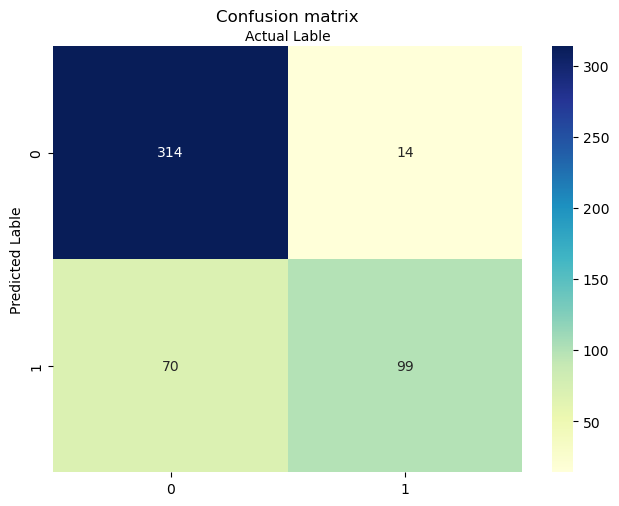

In [107]:
cnf_matrix = confusion_matrix(y_test,y_pred)
class_names = [0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks,class_names)
plt.yticks(tick_marks,class_names)


#Create Heatmap

sns.heatmap(pd.DataFrame(cnf_matrix), annot= True, cmap = "YlGnBu", fmt ="g")
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title("Confusion matrix")
plt.xlabel("Actual Lable")
plt.ylabel("Predicted Lable")

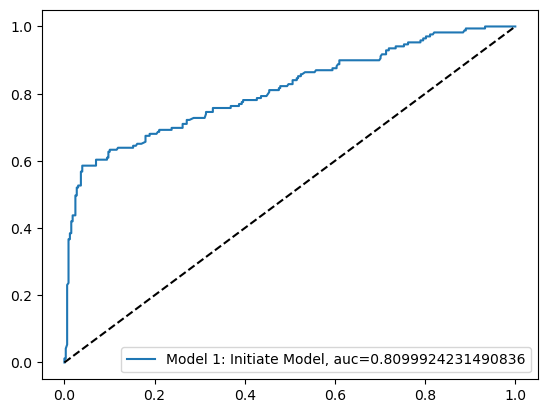

In [111]:
y_pred_proba = pipeline.predict_proba(X_test)[::,1]

fpr,tpr,_ = roc_curve(y_test,y_pred_proba)
auc = roc_auc_score(y_test,y_pred_proba)

plt.plot(fpr, tpr, label= "Model: Initiate Model, auc=" +str(auc))
plt.plot([0,1], [0,1], color = "black", linestyle = '--')
plt.legend(loc=4)
plt.show()

In [113]:
# Fits the explainer
explainer = shap.Explainer(pipeline.predict, X_test)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test)

Exact explainer: 498it [03:29,  2.31it/s]                         


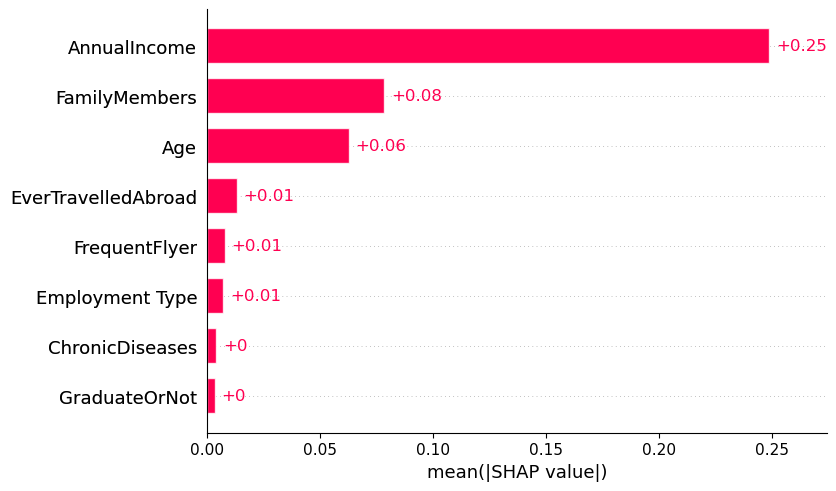

In [114]:
shap.plots.bar(shap_values)

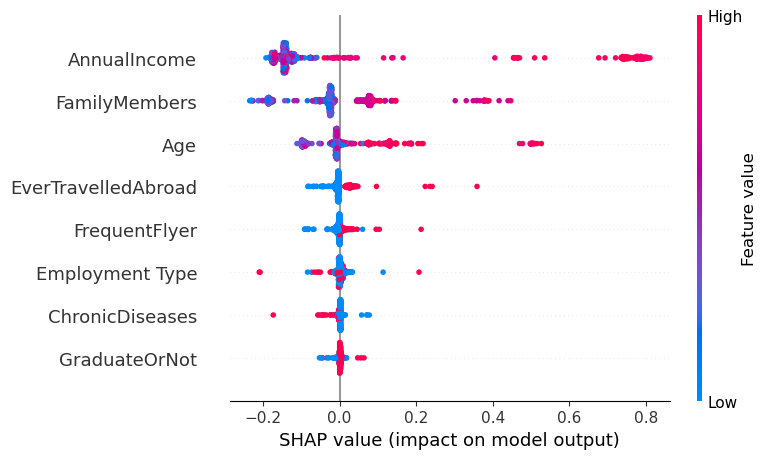

In [115]:
shap.summary_plot(shap_values)

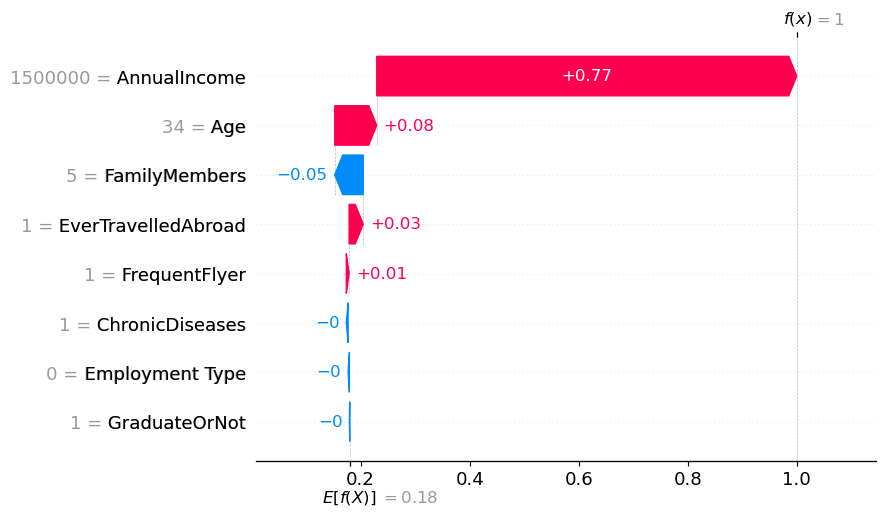

In [116]:
shap.plots.waterfall(shap_values[0])

In [117]:
shap.initjs()
shap.plots.force(shap_values[0])